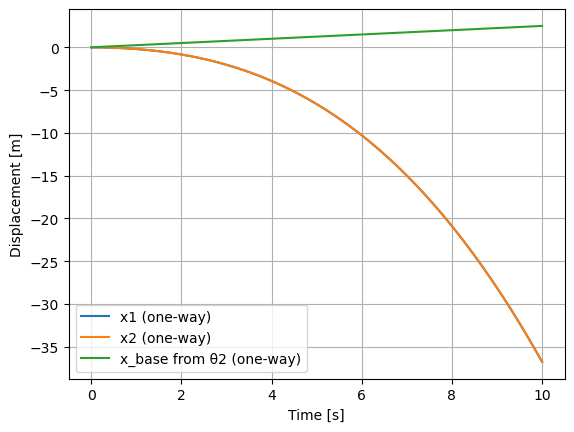

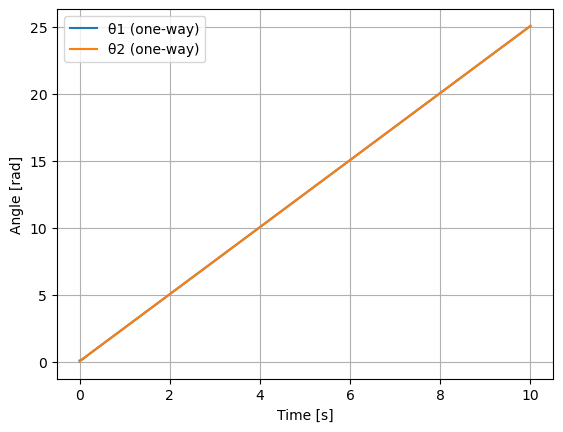

In [3]:
# Re-import necessary libraries after kernel reset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# System parameters (arbitrary reasonable values)
m1 = 1.0      # kg
m2 = 1.0      # kg
k = 100.0     # N/m
c = 5.0       # Ns/m

I1 = 0.1      # kg·m²
I2 = 0.1      # kg·m²
kt = 50.0     # Nm/rad
ct = 2.0      # Nms/rad

R = 0.1       # radius coupling torsion to translation (e.g. crank radius) in meters

# Modified dynamics: One-way coupling (torque excites translation, no feedback)
def one_way_dynamics(t, y):
    # Unpack state vector
    x1, x1_dot, x2, x2_dot, th1, th1_dot, th2, th2_dot = y

    # Torsional torques
    T_spring = kt * (th1 - th2)
    T_damper = ct * (th1_dot - th2_dot)

    th1_ddot = (-T_spring - T_damper) / I1
    th2_ddot = (T_spring + T_damper) / I2

    # Base excitation from torsional system (as x_base = R * theta2)
    x_base_ddot = R * th2_dot**2 + R * th2  # approximate second derivative
    F_base = -m1 * x_base_ddot  # inertial force from rotating base
    
    # Translational forces
    F_spring = k * (x1 - x2)
    F_damper = c * (x1_dot - x2_dot)

    # Translational accelerations (only affected by torsional system, not vice versa)
    x1_ddot = (-F_spring - F_damper + F_base) / m1
    x2_ddot = (F_spring + F_damper) / m2

    return [x1_dot, x1_ddot, x2_dot, x2_ddot, th1_dot, th1_ddot, th2_dot, th2_ddot]

# Initial conditions: [x1, x1_dot, x2, x2_dot, th1, th1_dot, th2, th2_dot]
y0 = [0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 5.0]

# Time span
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

# Solve ODE for one-way coupled system
sol_one_way = solve_ivp(one_way_dynamics, t_span, y0, t_eval=t_eval)

# Plot comparison
fig, ax = plt.subplots()
ax.plot(sol_one_way.t, sol_one_way.y[0], label='x1 (one-way)')
ax.plot(sol_one_way.t, sol_one_way.y[2], label='x2 (one-way)')
ax.plot(sol_one_way.t, R * sol_one_way.y[6], label='x_base from θ2 (one-way)')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Displacement [m]')
ax.legend()
ax.grid()

fig2, ax2 = plt.subplots()
ax2.plot(sol_one_way.t, sol_one_way.y[4], label='θ1 (one-way)')
ax2.plot(sol_one_way.t, sol_one_way.y[6], label='θ2 (one-way)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Angle [rad]')
ax2.legend()
ax2.grid()

plt.show()


## Frequency Domain

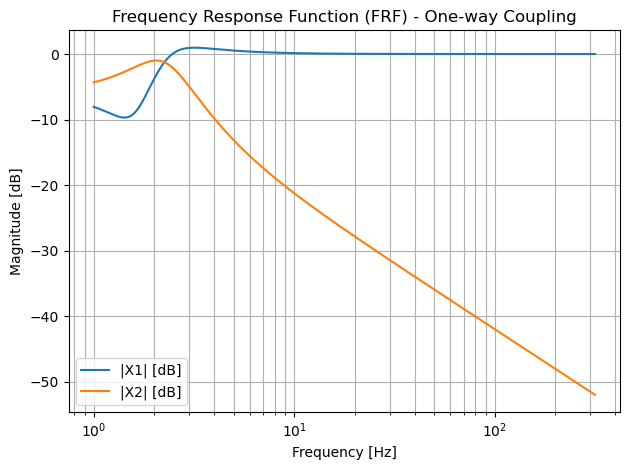

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m1 = 1.0      # kg
m2 = 1.0      # kg
k = 100.0     # N/m
c = 5.0       # Ns/m

# Frequency sweep parameters
frequencies = np.logspace(0, 2.5, 500)  # from 1 to ~316 Hz
omega = 2 * np.pi * frequencies         # angular frequencies
A = 1.0                                 # unit amplitude base excitation

# Allocate output arrays
X1_mag = np.zeros_like(omega)
X2_mag = np.zeros_like(omega)

# Frequency domain solution
for i, w in enumerate(omega):
    # Construct dynamic stiffness matrix H(w) * [X1, X2] = B(w)
    H = np.array([
        [-m1 * w**2 + k + 1j * w * c, -k - 1j * w * c],
        [-k - 1j * w * c, -m2 * w**2 + k + 1j * w * c]
    ])
    
    # Right-hand side (excitation from base)
    B = np.array([m1 * w**2 * A, 0.0])

    # Solve for [X1, X2]
    X = np.linalg.solve(H, B)

    # Store magnitudes
    X1_mag[i] = np.abs(X[0])
    X2_mag[i] = np.abs(X[1])

# Plot FRF magnitude
plt.figure()
plt.semilogx(frequencies, 20 * np.log10(X1_mag), label='|X1| [dB]')
plt.semilogx(frequencies, 20 * np.log10(X2_mag), label='|X2| [dB]')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency Response Function (FRF) - One-way Coupling')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


## Mock Simple Swingarm system

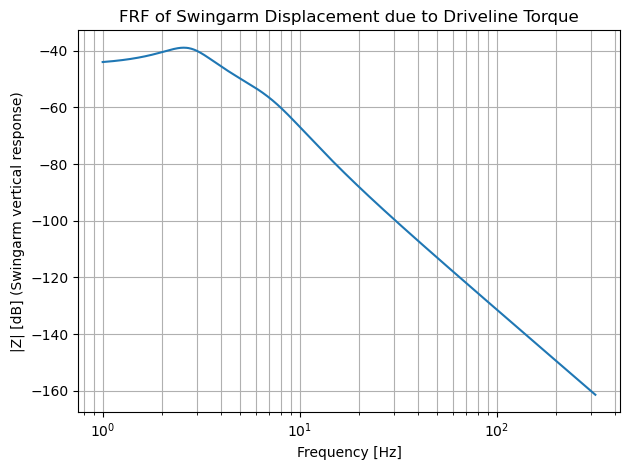

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m_swingarm = 1.0     # kg (mass of swingarm structure)
k_sa = 300.0         # N/m (suspension stiffness)
c_sa = 10.0          # Ns/m (suspension damping)

I_drive = 0.1        # kg·m² (driveline inertia)
I_wheel = 0.1        # kg·m² (wheel inertia)
kt = 100.0           # Nm/rad (driveline stiffness)
ct = 2.0             # Nms/rad (driveline damping)

R_wheel = 0.3        # m (wheel radius)

# Frequency sweep
frequencies = np.logspace(0, 2.5, 500)  # Hz
omega = 2 * np.pi * frequencies         # rad/s

# Store FRF of swingarm vertical displacement
Z_mag = np.zeros_like(omega)

# Sweep over frequencies
for i, w in enumerate(omega):
    # Driveline torsional system (2 inertias)
    # Output torque transmitted from driveline to wheel
    # Assume base excitation torque: T_in = A = 1 Nm
    T_drive = 1.0
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([T_drive, 0.0])
    theta = np.linalg.solve(H_torsion, B_torsion)
    T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])

    # Ground force from torque
    F_ground = T_wheel / R_wheel

    # Swingarm modeled as translational oscillator with F_ground input
    Z = F_ground / (-m_swingarm * w**2 + k_sa + 1j * w * c_sa)
    Z_mag[i] = np.abs(Z)

# Plot FRF
plt.figure()
plt.semilogx(frequencies, 20 * np.log10(Z_mag))
plt.xlabel('Frequency [Hz]')
plt.ylabel('|Z| [dB] (Swingarm vertical response)')
plt.title('FRF of Swingarm Displacement due to Driveline Torque')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


## Next LEvel


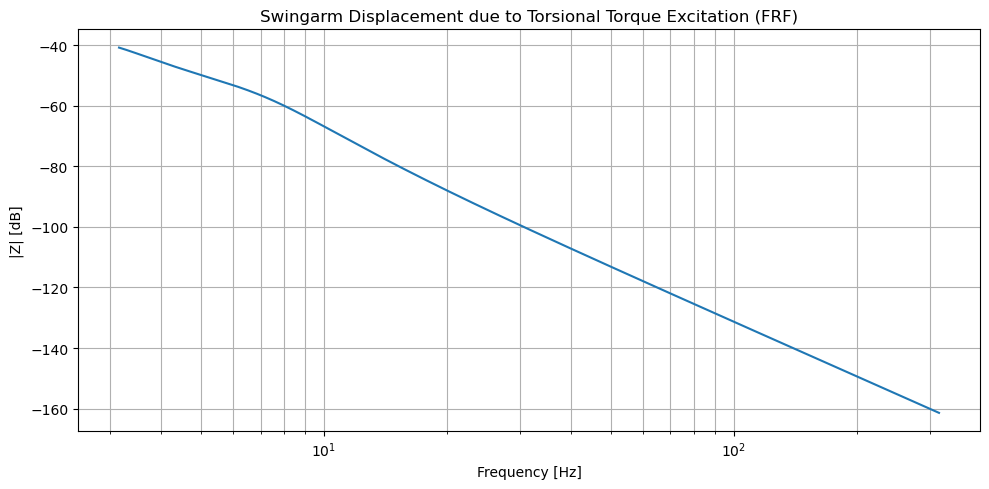

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m_swingarm = 1.0     # kg (mass of swingarm structure)
k_sa = 300.0         # N/m (suspension stiffness)
c_sa = 10.0          # Ns/m (suspension damping)

I_drive = 0.1        # kg·m² (driveline inertia)
I_wheel = 0.1        # kg·m² (wheel inertia)
kt = 100.0           # Nm/rad (driveline stiffness)
ct = 2.0             # Nms/rad (driveline damping)

R_wheel = 0.3        # m (wheel radius)

# Frequency sweep setup
frequencies = np.logspace(0.5, 2.5, 1000)  # from ~3 Hz to ~316 Hz
omega = 2 * np.pi * frequencies            # angular frequency

# Output arrays
Z_mag = np.zeros_like(omega)

# Sweep over frequency and compute swingarm response
for i, w in enumerate(omega):
    # Input: unit torque at driveline input
    T_drive = 1.0

    # Driveline dynamic stiffness matrix
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([T_drive, 0.0])
    theta = np.linalg.solve(H_torsion, B_torsion)

    # Torque transmitted to wheel
    T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])

    # Ground force from torque
    F_ground = T_wheel / R_wheel

    # Swingarm response: Z = displacement from force
    Z = F_ground / (-m_swingarm * w**2 + k_sa + 1j * w * c_sa)
    Z_mag[i] = np.abs(Z)

# Plot FRF result
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, 20 * np.log10(Z_mag))
plt.xlabel('Frequency [Hz]')
plt.ylabel('|Z| [dB]')
plt.title('Swingarm Displacement due to Torsional Torque Excitation (FRF)')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


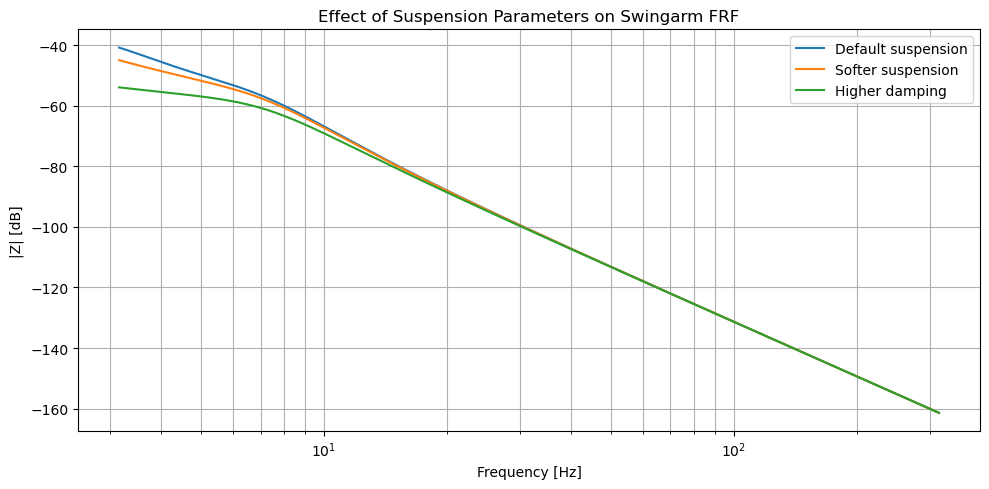

In [7]:
# Prepare output arrays for multiple cases
Z_mag_default = np.zeros_like(omega)
Z_mag_soft_suspension = np.zeros_like(omega)
Z_mag_high_damping = np.zeros_like(omega)

# Modified parameters
k_sa_soft = 100.0     # N/m, soft suspension
c_sa_high = 50.0      # Ns/m, high damping

# Function to compute swingarm FRF
def compute_FRF(k_sa_val, c_sa_val):
    Z_mag = np.zeros_like(omega)
    for i, w in enumerate(omega):
        # Driveline response (same in all cases)
        T_drive = 1.0
        H_torsion = np.array([
            [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
            [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
        ])
        B_torsion = np.array([T_drive, 0.0])
        theta = np.linalg.solve(H_torsion, B_torsion)
        T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])
        F_ground = T_wheel / R_wheel
        Z = F_ground / (-m_swingarm * w**2 + k_sa_val + 1j * w * c_sa_val)
        Z_mag[i] = np.abs(Z)
    return Z_mag

# Compute FRFs for each configuration
Z_mag_default = compute_FRF(k_sa, c_sa)
Z_mag_soft_suspension = compute_FRF(k_sa_soft, c_sa)
Z_mag_high_damping = compute_FRF(k_sa, c_sa_high)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, 20 * np.log10(Z_mag_default), label='Default suspension')
plt.semilogx(frequencies, 20 * np.log10(Z_mag_soft_suspension), label='Softer suspension')
plt.semilogx(frequencies, 20 * np.log10(Z_mag_high_damping), label='Higher damping')
plt.xlabel('Frequency [Hz]')
plt.ylabel('|Z| [dB]')
plt.title('Effect of Suspension Parameters on Swingarm FRF')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


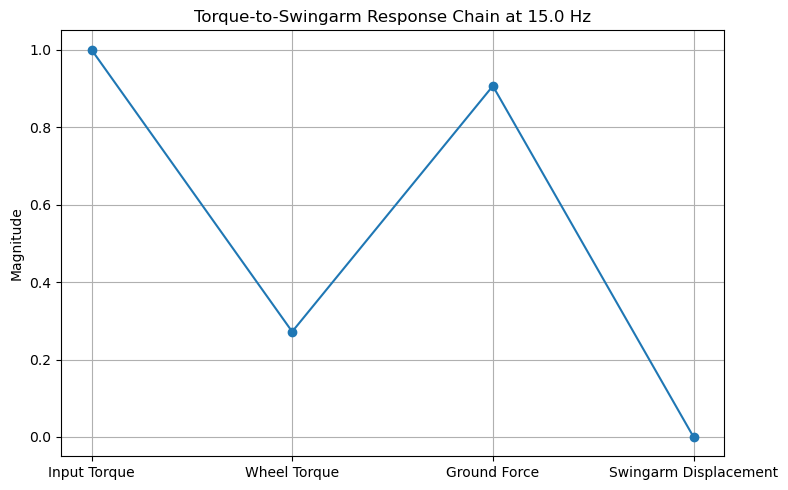

In [8]:
# Choose a representative frequency for detailed visualization
freq_target = 15.0  # Hz, near the swingarm resonance
w = 2 * np.pi * freq_target

# Driveline torque input
T_drive = 1.0

# Compute driveline response
H_torsion = np.array([
    [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
    [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
])
B_torsion = np.array([T_drive, 0.0])
theta = np.linalg.solve(H_torsion, B_torsion)

# Torque transmitted to wheel
T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])

# Force at ground from wheel torque
F_ground = T_wheel / R_wheel

# Swingarm displacement
Z = F_ground / (-m_swingarm * w**2 + k_sa + 1j * w * c_sa)

# Normalize for plotting
T_drive_mag = np.abs(T_drive)
T_wheel_mag = np.abs(T_wheel)
F_ground_mag = np.abs(F_ground)
Z_mag = np.abs(Z)

# Build stage-wise chain
stages = ['Input Torque', 'Wheel Torque', 'Ground Force', 'Swingarm Displacement']
magnitudes = [T_drive_mag, T_wheel_mag, F_ground_mag, Z_mag]

# Plot transformation chain
plt.figure(figsize=(8, 5))
plt.plot(stages, magnitudes, marker='o')
plt.title(f'Torque-to-Swingarm Response Chain at {freq_target} Hz')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Frequencies for step-by-step breakdown
freqs_to_check = [5, 10, 15, 20, 30, 50, 80, 120]  # Hz

# Containers for tabulated results
results = []

for freq in freqs_to_check:
    w = 2 * np.pi * freq
    T_drive = 1.0

    # Driveline solution
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([T_drive, 0.0])
    theta = np.linalg.solve(H_torsion, B_torsion)

    T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])
    F_ground = T_wheel / R_wheel
    Z = F_ground / (-m_swingarm * w**2 + k_sa + 1j * w * c_sa)

    # Energies (average energy per cycle for sinusoidal signals)
    E_drive = 0.5 * I_drive * (w * np.abs(theta[0]))**2
    E_wheel = 0.5 * I_wheel * (w * np.abs(theta[1]))**2
    E_spring = 0.5 * k_sa * (np.abs(Z))**2
    P_damping = 0.5 * c_sa * (w * np.abs(Z))**2  # average power dissipation

    results.append({
        'Frequency [Hz]': freq,
        '|T_wheel| [Nm]': np.abs(T_wheel),
        '|F_ground| [N]': np.abs(F_ground),
        '|Z| [m]': np.abs(Z),
        'E_drive [J]': E_drive,
        'E_wheel [J]': E_wheel,
        'E_spring [J]': E_spring,
        'P_damping [W]': P_damping
    })

# Convert to DataFrame and display
import pandas as pd


df_results = pd.DataFrame(results)


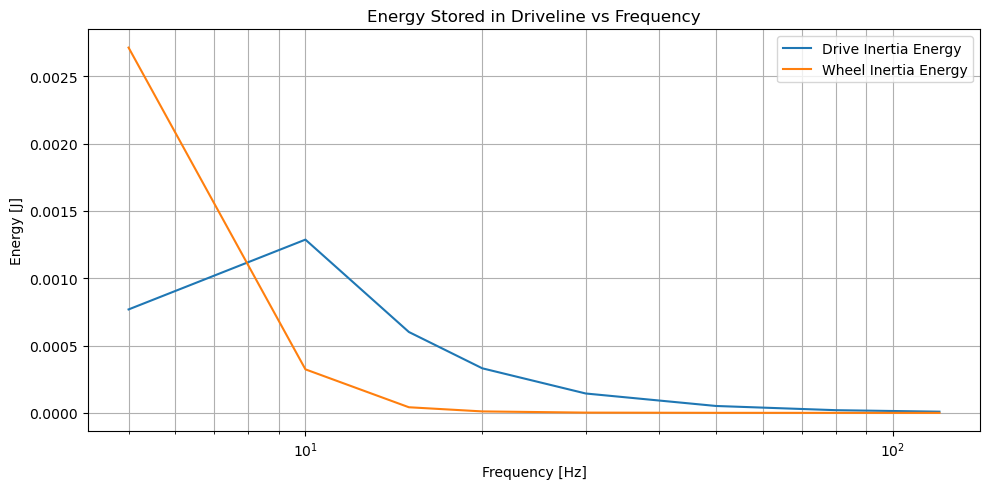

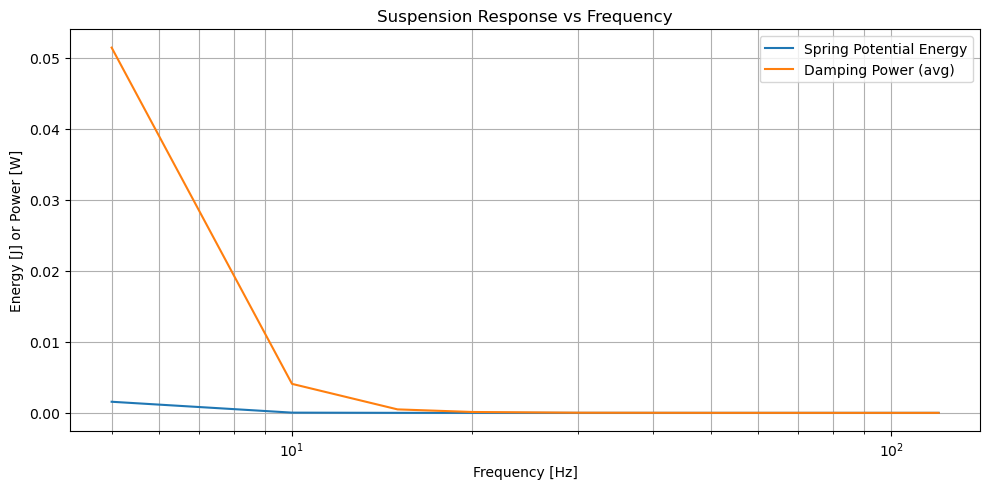

In [12]:
# Extract energy-related quantities for plotting
frequencies = df_results["Frequency [Hz]"]
E_drive = df_results["E_drive [J]"]
E_wheel = df_results["E_wheel [J]"]
E_spring = df_results["E_spring [J]"]
P_damping = df_results["P_damping [W]"]

# Plot energy stored in drive and wheel
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, E_drive, label="Drive Inertia Energy")
plt.semilogx(frequencies, E_wheel, label="Wheel Inertia Energy")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy [J]")
plt.title("Energy Stored in Driveline vs Frequency")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Plot energy in suspension (spring + damping)
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, E_spring, label="Spring Potential Energy")
plt.semilogx(frequencies, P_damping, label="Damping Power (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy [J] or Power [W]")
plt.title("Suspension Response vs Frequency")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()
